In [120]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as ra
import shapely as shp
import rioxarray as rx
import rasterstats as rs
import cartopy as cp
import cartopy.crs as ccrs

In [121]:
import warnings
warnings.filterwarnings('ignore')

In [122]:
%matplotlib inline

## Mortality data

In [166]:
deaths = pd.read_csv('./weekly_deaths.csv', thousands=',')
deaths['Week Ending Date'] = pd.to_datetime(deaths['Week Ending Date'])
deaths = deaths.groupby(['Jurisdiction of Occurrence', 'Week Ending Date']).min()
deaths.tail()

Data As Of  MMWR Year  MMWR Week  \
Jurisdiction of Occurrence Week Ending Date                                     
Wyoming                    2021-11-20        12/29/2021       2021         46   
                           2021-11-27        12/29/2021       2021         47   
                           2021-12-04        12/29/2021       2021         48   
                           2021-12-11        12/29/2021       2021         49   
                           2021-12-18        12/29/2021       2021         50   

                                             All Cause  Natural Cause  \
Jurisdiction of Occurrence Week Ending Date                             
Wyoming                    2021-11-20              132            121   
                           2021-11-27              123            115   
                           2021-12-04               99             93   
                           2021-12-11               78             76   
                           2021-12-18               37             37   

                                             Septicemia (A40-A41)  \
Jurisdiction of Occurrence Week Ending Date                         
Wyoming                    2021-11-20                         NaN   
                           2021-11-27                         0.0   
                           2021-12-04                         0.0   
                           2021-12-11                         0.0   
                           2021-12-18                         0.0   

                                             Malignant neoplasms (C00-C97)  \
Jurisdiction of Occurrence Week Ending Date                                  
Wyoming                    2021-11-20                                 15.0   
                           2021-11-27                                 18.0   
                           2021-12-04                                 17.0   
                           2021-12-11                                  NaN   
                           2021-12-18                                  NaN   

                                             Diabetes mellitus (E10-E14)  \
Jurisdiction of Occurrence Week Ending Date                                
Wyoming                    2021-11-20                                NaN   
                           2021-11-27                                NaN   
                           2021-12-04                                NaN   
                           2021-12-11                                NaN   
                           2021-12-18                                NaN   

                                             Alzheimer disease (G30)  \
Jurisdiction of Occurrence Week Ending Date                            
Wyoming                    2021-11-20                            NaN   
                           2021-11-27                            NaN   
                           2021-12-04                            NaN   
                           2021-12-11                            NaN   
                           2021-12-18                            0.0   

                                             Influenza and pneumonia (J09-J18)  \
Jurisdiction of Occurrence Week Ending Date                                      
Wyoming                    2021-11-20                                      NaN   
                           2021-11-27                                      0.0   
                           2021-12-04                                      NaN   
                           2021-12-11                                      NaN   
                           2021-12-18                                      0.0   

                                             ...                 flag_alz  \
Jurisdiction of Occurrence Week Ending Date  ...                            
Wyoming                    2021-11-20        ...  Suppressed (counts 1-9)   
                           2021-11-27        ...  Suppressed (counts 1-9)   
             

In [167]:
deaths.columns

Index(['Data As Of', 'MMWR Year', 'MMWR Week', 'All Cause', 'Natural Cause',
       'Septicemia (A40-A41)', 'Malignant neoplasms (C00-C97)',
       'Diabetes mellitus (E10-E14)', 'Alzheimer disease (G30)',
       'Influenza and pneumonia (J09-J18)',
       'Chronic lower respiratory diseases (J40-J47)',
       'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)',
       'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)',
       'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
       'Diseases of heart (I00-I09,I11,I13,I20-I51)',
       'Cerebrovascular diseases (I60-I69)',
       'COVID-19 (U071, Multiple Cause of Death)',
       'COVID-19 (U071, Underlying Cause of Death)', 'flag_allcause',
       'flag_natcause', 'flag_sept', 'flag_neopl', 'flag_diab', 'flag_alz',
       'flag_inflpn', 'flag_clrd', 'flag_otherresp', 'flag_nephr',
       'flag_otherunk', 'flag_hd', 'flag_stroke', 'flag_cov19mcod',

In [168]:
deaths = deaths[['Diseases of heart (I00-I09,I11,I13,I20-I51)']].unstack(level=-2)

In [198]:
# deaths = deaths.resample('1W').sum()
deaths

Jurisdiction of Occurrence,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,United States,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Week Ending Date,,,,,,,,,,,,,,,,,,,,,
2020-01-04,268.0,17.0,314.0,174.0,1394.0,177.0,160.0,50.0,33.0,1013.0,...,385.0,1001.0,14202.0,76.0,25.0,299.0,245.0,102.0,271.0,30.0
2020-01-11,274.0,24.0,299.0,165.0,1384.0,168.0,135.0,45.0,26.0,1023.0,...,341.0,1003.0,13911.0,85.0,24.0,293.0,260.0,111.0,236.0,18.0
2020-01-18,239.0,15.0,275.0,167.0,1397.0,164.0,151.0,46.0,33.0,1000.0,...,365.0,966.0,13595.0,82.0,38.0,311.0,225.0,114.0,243.0,20.0
2020-01-25,284.0,19.0,282.0,161.0,1361.0,147.0,155.0,48.0,26.0,1003.0,...,339.0,992.0,13610.0,68.0,32.0,311.0,272.0,112.0,217.0,27.0
2020-02-01,265.0,20.0,287.0,151.0,1353.0,146.0,164.0,35.0,41.0,993.0,...,373.0,959.0,13463.0,78.0,28.0,315.0,262.0,107.0,285.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-20,229.0,10.0,297.0,157.0,1106.0,158.0,101.0,31.0,15.0,894.0,...,317.0,898.0,12208.0,82.0,41.0,324.0,268.0,NaN,249.0,24.0
2021-11-27,244.0,13.0,303.0,183.0,1097.0,160.0,80.0,42.0,31.0,903.0,...,336.0,823.0,12065.0,79.0,27.0,328.0,237.0,NaN,262.0,25.0
2021-12-04,267.0,16.0,257.0,146.0,992.0,157.0,71.0,42.0,16.0,888.0,...,324.0,798.0,11259.0,78.0,33.0,338.0,221.0,NaN,239.0,12.0


In [170]:
deaths = deaths.droplevel(0, axis=1)

<AxesSubplot:xlabel='Week Ending Date'>

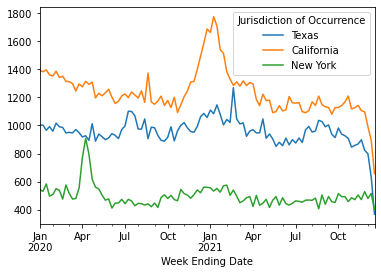

In [171]:
deaths[['Texas', 'California', 'New York']].plot()

## Temperature data

In [240]:
ds = xr.open_dataset('tmax.2020.nc')
ds = ds.sortby('lat')
ds = ds.rio.write_crs('epsg:4326')
ds['lon'] = xr.where(ds['lon'] > 180, ds['lon']-360, ds['lon'])
ds = ds.sortby('lon')
ds

<xarray.Dataset>
Dimensions:      (lat: 360, lon: 720, time: 366)
Coordinates:
  * lat          (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon          (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time         (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
    spatial_ref  int32 0
Data variables:
    tmax         (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/wd52ws/global_temp/
    version:        V1.0
    title:          CPC GLOBAL TEMP V1.0
    dataset_title:  CPC GLOBAL TEMP
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globaltemp...
    history:        Updated 2021-01-02 16:49:38

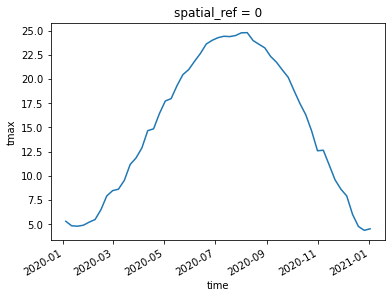

In [232]:
t = ds['tmax'].resample(time='1W', loffset='-1D').mean()
t.mean(['lat', 'lon']).plot()

### State geometries

In [482]:
states = gpd.read_file('./cb_2018_us_state_5m.zip')
states = states[~states.NAME.isin(['Alaska', 'Hawaii', 'Commonwealth of the Northern Mariana Islands', 
                                   'Guam', 'American Samoa', 'Puerto Rico', 'United States Virgin Islands'])]
states = states.to_crs('epsg:4326')
states.tail()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
46,11,01702382,0400000US11,11,DC,District of Columbia,00,158340391,18687198,"POLYGON ((-77.11976 38.93434, -77.10450 38.946..."
50,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.63971 42.73707, -96.63589 42.741..."
52,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.55929 36.499..."
53,47,01325873,0400000US47,47,TN,Tennessee,00,106802728188,2350123465,"POLYGON ((-90.30988 35.00975, -90.30690 35.018..."
54,17,01779784,0400000US17,17,IL,Illinois,00,143780567633,6214824948,"POLYGON ((-91.51297 40.18106, -91.51107 40.188..."


In [483]:
usa = states.total_bounds
usa

array([-124.73317221,   24.51495958,  -66.94989432,   49.384358  ])

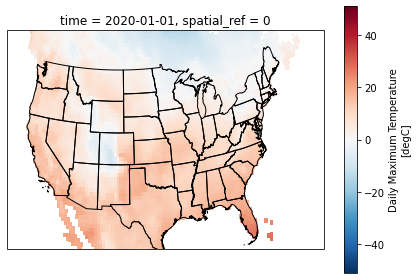

In [484]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Orthographic(central_longitude=-105, central_latitude=36)})
ds_ = ds.isel(time=0)['tmax']
ds_.plot(ax=ax, transform=ccrs.PlateCarree())
states.plot(ax=ax, fc='None', ec='k', transform=ccrs.PlateCarree())
ax.set_extent([usa[0], usa[2], usa[1], usa[3]], crs=ccrs.PlateCarree())
plt.tight_layout()

In [507]:
l = []

# go through all states
for i, row in states.iterrows():
    
    state = row.NAME
    print(state)
    
    state_df = deaths[[state]]
    state_df['temp_%s'%state] = np.nan
    
    mask = rm.mask_geopandas(gpd.GeoDataFrame(geometry=[row.geometry]),lon_or_obj=t.lon, lat=t.lat)

    # go through all weeks and compute zonal statistics
    for w in range(len(t.time)):
        
        # get values of variable pear month
        ds_week = t.isel(time=w)
#         print(ds_week.mean().values)
        out = float(ds_week.where(mask>=0, np.nan).max().values)
#         print(out)
        state_df.loc[t.time[w].values, 'temp_%s'%state] = out
    
    l.append(state_df)

Nebraska
Washington
New Mexico
South Dakota
Texas
California
Kentucky
Ohio
Alabama
Georgia
Wisconsin
Oregon
Pennsylvania
Mississippi
Missouri
North Carolina
Oklahoma
West Virginia
New York
Indiana
Kansas
Idaho
Nevada
Vermont
Montana
Minnesota
North Dakota
Arizona
Delaware
Rhode Island
Colorado
Utah
Virginia
Wyoming
Louisiana
Michigan
Massachusetts
Florida
Connecticut
New Jersey
Maryland
South Carolina
Maine
New Hampshire
District of Columbia
Iowa
Arkansas
Tennessee
Illinois


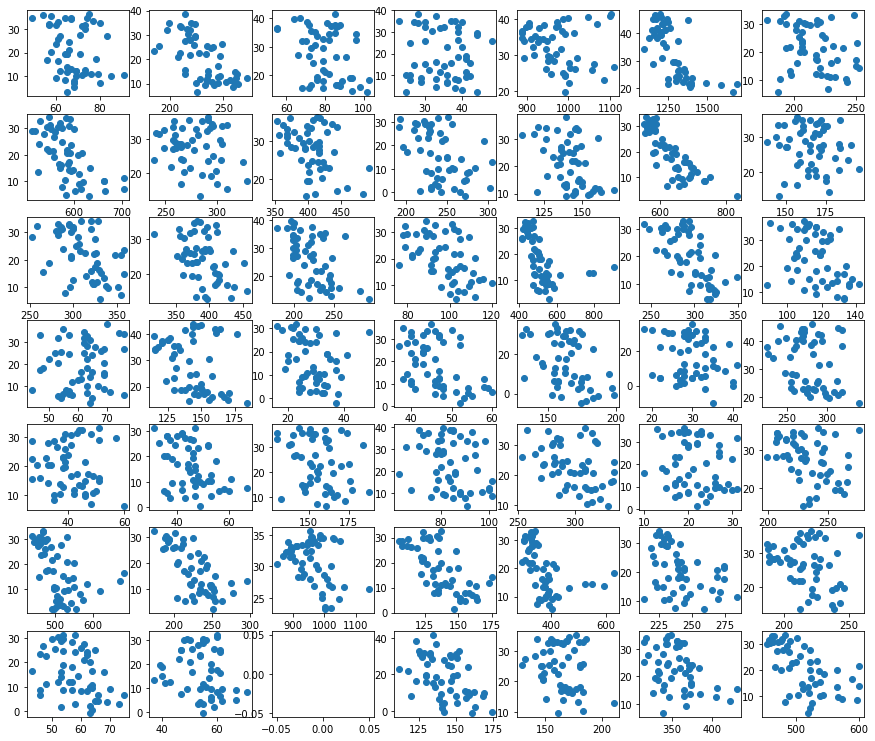

In [509]:
fig, axs = plt.subplots(7,7, figsize=(15,13))

for i, ax in enumerate(axs.flatten()[:49]):
    ax.scatter(l[i].iloc[:,0], l[i].iloc[:,1])
#     print(i)
    
plt.show()

In [521]:
pd.concat(l, axis=1).to_excel('temp_mortality_data.xlsx')